In [1]:
import os
import sys

import pandas as pd

sys.path.append('/Users/samrelins/Documents/LIDA/dental_project/src/')

from baseline_data_prep import *
from education_data_prep import *
from analysis_helpers import *
from platoon_data_prep import *
from tableone import TableOne

In [2]:

# prep dicts to store model results
model_scores = {
    "Data": [],
    "Model Type": [],
    "Pseudo R^2": [],
    "Train ROC AUC": [],
    "Test ROC AUC": []
}

log_reg_roc_curves = {}
las_reg_roc_curves = {}
gb_roc_curves = {}

# load epi data and create caries_experience target

bib_dir = "/users/samrelins/documents/lida/dental_project/data/bib_data"
epi_path = os.path.join(bib_dir, "dental/dsurvey_5yo/data.csv")
epi_data = pd.read_csv(epi_path)
epi_data["caries_experience"] = (epi_data.ddsdmft > 0).astype("int")

In [3]:
### edrecs models ###

# load edrecs data and merge with epi caries_experience target

edrecs_data = return_merged_edrecs_df(bib_dir)

edrecs_caries = (epi_data[["entity_id", "caries_experience"]]
                 .merge(edrecs_data,
                        on="entity_id",
                        how="left"))

# train unreg logistic regression model

ed_car_train, ed_car_test = train_test_split_by_target(
    edrecs_caries.dropna(),
    "caries_experience"
)

drop_features = ["entity_id", 'eal', 'looked_after', "caries_experience"]

features = edrecs_caries.drop(drop_features, axis=1).columns
patsy_string = f"caries_experience ~ "
patsy_string += " + ".join(features)

edrecs_mod = sm.Logit.from_formula(patsy_string, data=ed_car_train)
edrecs_unreg_results = edrecs_mod.fit(maxiter=100,
                  disp=True)

# store unreg log reg model performance stats

ed_un_data = return_model_performance_stats(edrecs_unreg_results,
                                            ed_car_train,
                                            ed_car_test)

model_scores["Data"].append("edrecs")
model_scores["Model Type"].append("Logistic Regression")
model_scores["Pseudo R^2"].append(ed_un_data[0])
model_scores["Train ROC AUC"].append(ed_un_data[1])
model_scores["Test ROC AUC"].append(ed_un_data[3])

log_reg_roc_curves["Edrecs Train"] = ed_un_data[2]
log_reg_roc_curves["Edrecs Test"] = ed_un_data[4]

# train lasso model

edrecs_reg_results = edrecs_mod.fit_regularized(alpha=1,
                              maxiter=100,
                              disp=True)

ed_reg_data = return_model_performance_stats(edrecs_reg_results,
                                             ed_car_train,
                                             ed_car_test)

model_scores["Data"].append("edrecs")
model_scores["Model Type"].append("Lasso Logistic Regression")
model_scores["Pseudo R^2"].append(ed_reg_data[0])
model_scores["Train ROC AUC"].append(ed_reg_data[1])
model_scores["Test ROC AUC"].append(ed_reg_data[3])

las_reg_roc_curves["Edrecs Train"] = ed_reg_data[2]
las_reg_roc_curves["Edrecs Test"] = ed_reg_data[4]

# train Grad Boost model and test eval

drop_features = ["entity_id", 'eal', 'looked_after']
edrecs_gb_clf = cv_train_gb_classifier(ed_car_train.drop(drop_features,
                                                          axis=1),
                                       "caries_experience")

ed_gb_data = return_model_performance_stats(edrecs_gb_clf,
                                            ed_car_train.drop(drop_features,
                                                              axis=1),
                                            ed_car_test.drop(drop_features,
                                                             axis=1))

model_scores["Data"].append("edrecs")
model_scores["Model Type"].append("Gradient Boosted Trees")
model_scores["Pseudo R^2"].append(ed_gb_data[0])
model_scores["Train ROC AUC"].append(ed_gb_data[1])
model_scores["Test ROC AUC"].append(ed_gb_data[3])

gb_roc_curves["Edrecs Train"] = ed_gb_data[2]
gb_roc_curves["Edrecs Test"] = ed_gb_data[4]

Optimization terminated successfully.
         Current function value: 0.509027
         Iterations 8
Train ROC/AUC = 0.8214285714285714. Test ROC/AUC = 0.5900641025641026
Iteration limit reached    (Exit mode 9)
            Current function value: 0.6135850609813711
            Iterations: 100
            Function evaluations: 102
            Gradient evaluations: 100
Train ROC/AUC = 0.7937939110070259. Test ROC/AUC = 0.6272435897435896
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/opt/anaconda3/envs/DentalEnv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train ROC/AUC = 0.8215456674473068. Test ROC/AUC = 0.6126602564102565


In [4]:
### baseline models ###

# load baseline data and merge caries_experience target

baseline_data = return_reduced_baseline_ga_df(bib_dir)
baseline_data.drop("has_dental_ga", axis=1, inplace=True)

baseline_caries = (epi_data[["entity_id", "caries_experience"]]
                   .merge(baseline_data,
                          on="entity_id",
                          how="left"))

# train unreg logistic regression model

base_car_train, base_car_test = train_test_split_by_target(
    baseline_caries.dropna(),
    "caries_experience"
)

drop_features = ['entity_id', 'managing_financially',
                 'mother_smoked', "caries_experience"]

base_features = baseline_caries.drop(drop_features, axis=1).columns
patsy_string = f"caries_experience ~ "
patsy_string += " + ".join(base_features)

base_mod = sm.Logit.from_formula(patsy_string, data=base_car_train)
base_unreg_results = base_mod.fit(maxiter=100,
                                    disp=True)

# compare train and test set performance

base_un_data = return_model_performance_stats(base_unreg_results,
                                              base_car_train,
                                              base_car_test)

model_scores["Data"].append("Baseline")
model_scores["Model Type"].append("Logistic Regression")
model_scores["Pseudo R^2"].append(base_un_data[0])
model_scores["Train ROC AUC"].append(base_un_data[1])
model_scores["Test ROC AUC"].append(base_un_data[3])

log_reg_roc_curves["Baseline Train"] = base_un_data[2]
log_reg_roc_curves["Baseline Test"] = base_un_data[4]


# train lasso model

base_reg_results = base_mod.fit_regularized(alpha=5,
                                            maxiter=100,
                                            disp=True)

# compare train and test set performance

base_reg_data = return_model_performance_stats(base_reg_results,
                                               base_car_train,
                                               base_car_test)

model_scores["Data"].append("Baseline")
model_scores["Model Type"].append("Lasso Logistic Regression")
model_scores["Pseudo R^2"].append(base_reg_data[0])
model_scores["Train ROC AUC"].append(base_reg_data[1])
model_scores["Test ROC AUC"].append(base_reg_data[3])

las_reg_roc_curves["Baseline Train"] = base_reg_data[2]
las_reg_roc_curves["Baseline Test"] = base_reg_data[4]

# train non-linear epi model and test eval

drop_features = ['entity_id', 'managing_financially',
                 'mother_smoked']

base_gb_clf = cv_train_gb_classifier(base_car_train.drop(drop_features,
                                                         axis=1),
                                     "caries_experience")

base_gb_data = return_model_performance_stats(base_gb_clf,
                                              base_car_train.drop(drop_features,
                                                                  axis=1),
                                              base_car_test.drop(drop_features,
                                                                 axis=1))

model_scores["Data"].append("Baseline")
model_scores["Model Type"].append("Gradient Boosted Trees")
model_scores["Pseudo R^2"].append(base_gb_data[0])
model_scores["Train ROC AUC"].append(base_gb_data[1])
model_scores["Test ROC AUC"].append(base_gb_data[3])

gb_roc_curves["Baseline Train"] = base_gb_data[2]
gb_roc_curves["Baseline Test"] = base_gb_data[4]

/Users/samrelins/Documents/LIDA/dental_project/src/baseline_data_prep.py:34: DtypeWarning: Columns (110,247,303) have mixed types.Specify dtype option on import or set low_memory=False.
  baseline_data = return_baseline_df(bib_dir, select_cols)


         Current function value: 0.515601
         Iterations: 100
Train ROC/AUC = 0.8137254901960784. Test ROC/AUC = 0.619281045751634
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6527404570579565
            Iterations: 25
            Function evaluations: 27
            Gradient evaluations: 25
Train ROC/AUC = 0.7152888182299948. Test ROC/AUC = 0.6296296296296295
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/opt/anaconda3/envs/DentalEnv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train ROC/AUC = 0.7975622681505035. Test ROC/AUC = 0.6612200435729847


In [5]:
### merged edrecs + baseline models ###

# merge datasets
eb_caries = (baseline_caries.merge(
    edrecs_caries.drop("caries_experience", axis=1),
    on="entity_id",
    how="outer"))

eb_car_train, eb_car_test = train_test_split_by_target(
    eb_caries.dropna(),
    "caries_experience"
)


# identify features that best explain the target
# fit individual log reg model for each feature and store r squared scores

skip_cols = ["entity_id", "caries_experience", "managing_financially",
             "mother_smoked", "eal", "gifted", "looked_after"]
feature_cols = [col for col in eb_caries.columns
                if col not in skip_cols]

results = dict(feature=[], prsquared=[])
for feature in feature_cols:
    keep_cols = [feature, "caries_experience"]
    eb_results = log_reg_model_of_feature(eb_car_train[keep_cols],
                                          "caries_experience",
                                          disp=False)
    results["feature"].append(feature)
    results["prsquared"].append(eb_results.prsquared)

feature_scores = (pd.DataFrame(results)
                  .sort_values("prsquared", ascending=False)
                  .reset_index(drop=True))


# train logistic regression model using best 10 features

best_features = list(feature_scores.iloc[0:10].feature)

patsy_string = f"caries_experience ~ "
patsy_string += " + ".join(best_features)

eb_mod = sm.Logit.from_formula(patsy_string, data=eb_car_train)
eb_unreg_results = eb_mod.fit(maxiter=100,
                                disp=True)

# store model performance stats
eb_un_data = return_model_performance_stats(eb_unreg_results,
                                            eb_car_train,
                                            eb_car_test)

model_scores["Data"].append("Edrecs + Baseline")
model_scores["Model Type"].append("Logistic Regression")
model_scores["Pseudo R^2"].append(eb_un_data[0])
model_scores["Train ROC AUC"].append(eb_un_data[1])
model_scores["Test ROC AUC"].append(eb_un_data[3])

log_reg_roc_curves["Edrecs Baseline Train"] = eb_un_data[2]
log_reg_roc_curves["Edrecs Baseline Test"] = eb_un_data[4]

# train lasso model

eb_reg_results = eb_mod.fit_regularized(alpha=5,
                                          maxiter=100,
                                          disp=True)


eb_reg_data = return_model_performance_stats(eb_reg_results,
                                             eb_car_train,
                                             eb_car_test)

model_scores["Data"].append("Edrecs + Baseline")
model_scores["Model Type"].append("Lasso Logistic Regression")
model_scores["Pseudo R^2"].append(eb_reg_data[0])
model_scores["Train ROC AUC"].append(eb_reg_data[1])
model_scores["Test ROC AUC"].append(eb_reg_data[3])

las_reg_roc_curves["Edrecs Baseline Train"] = eb_reg_data[2]
las_reg_roc_curves["Edrecs Baseline Test"] = eb_reg_data[4]

# train non-linear epi model and test eval

keep_cols = best_features + ["caries_experience"]
eb_gb_clf = cv_train_gb_classifier(eb_car_train[keep_cols],
                                     "caries_experience")

eb_gb_data = return_model_performance_stats(eb_gb_clf,
                                            eb_car_train[keep_cols],
                                            eb_car_test[keep_cols])

model_scores["Data"].append("edrecs + Baseline")
model_scores["Model Type"].append("Gradient Boosted Trees")
model_scores["Pseudo R^2"].append(eb_gb_data[0])
model_scores["Train ROC AUC"].append(eb_gb_data[1])
model_scores["Test ROC AUC"].append(eb_gb_data[3])

gb_roc_curves["Edrecs Baseline Train"] = eb_gb_data[2]
gb_roc_curves["Edrecs Basline Test"] = eb_gb_data[4]

/opt/anaconda3/envs/DentalEnv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/DentalEnv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.489371
         Iterations: 100
Train ROC/AUC = 0.8380353009259259. Test ROC/AUC = 0.5800595238095239
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6563102466560691
            Iterations: 40
            Function evaluations: 40
            Gradient evaluations: 40
Train ROC/AUC = 0.777054398148148. Test ROC/AUC = 0.6139880952380952
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/opt/anaconda3/envs/DentalEnv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train ROC/AUC = 0.7704716435185185. Test ROC/AUC = 0.6095238095238095


# "Caries Experience" Analysis

In the initial analysis, we saw only a weak relationship between the observations in the BiB data and GA experience. It was assumed there would be a much stronger relationship between social / economic factors and bad oral health outcomes - this contrary evidence lead us to the hypothesis that the GA target wasn't capturing a large proportion of these bad outcomes. To test this hypothesis, we now turn to the PHE dental epidemiology data to test an alternative target - "caries experience". Children with a dmft / DMFT > 0 are labeled as having "caries experience" and the same observations from the BiB data are used to model this new target.

### The Data:

The challenge with the epidemiology / "epi" dataset is its size - only 354 dmft observations have corresponding BiB entries. As in the initial analysis, models will use explanatory variables from the "Education Records" and "Mother Baseline Survey". Omitting entries with missing observations in each dataset, epi records merged with the education data have only 339 observations, merged with the baseline data there are only 263 observations, and a combination of the two only 251.

Table 1 statistics for the combined datasets, grouped by children with / without caries experience can be seen in ** APPENDIX **. Looking at the data, it is immediately apparent that there is a much more dramatic difference in the distribution of the "caries experience" / "no caries experience" populations than was seen when comparing "the GA" / "no GA" data. This is more apparent when visualising these distributions:

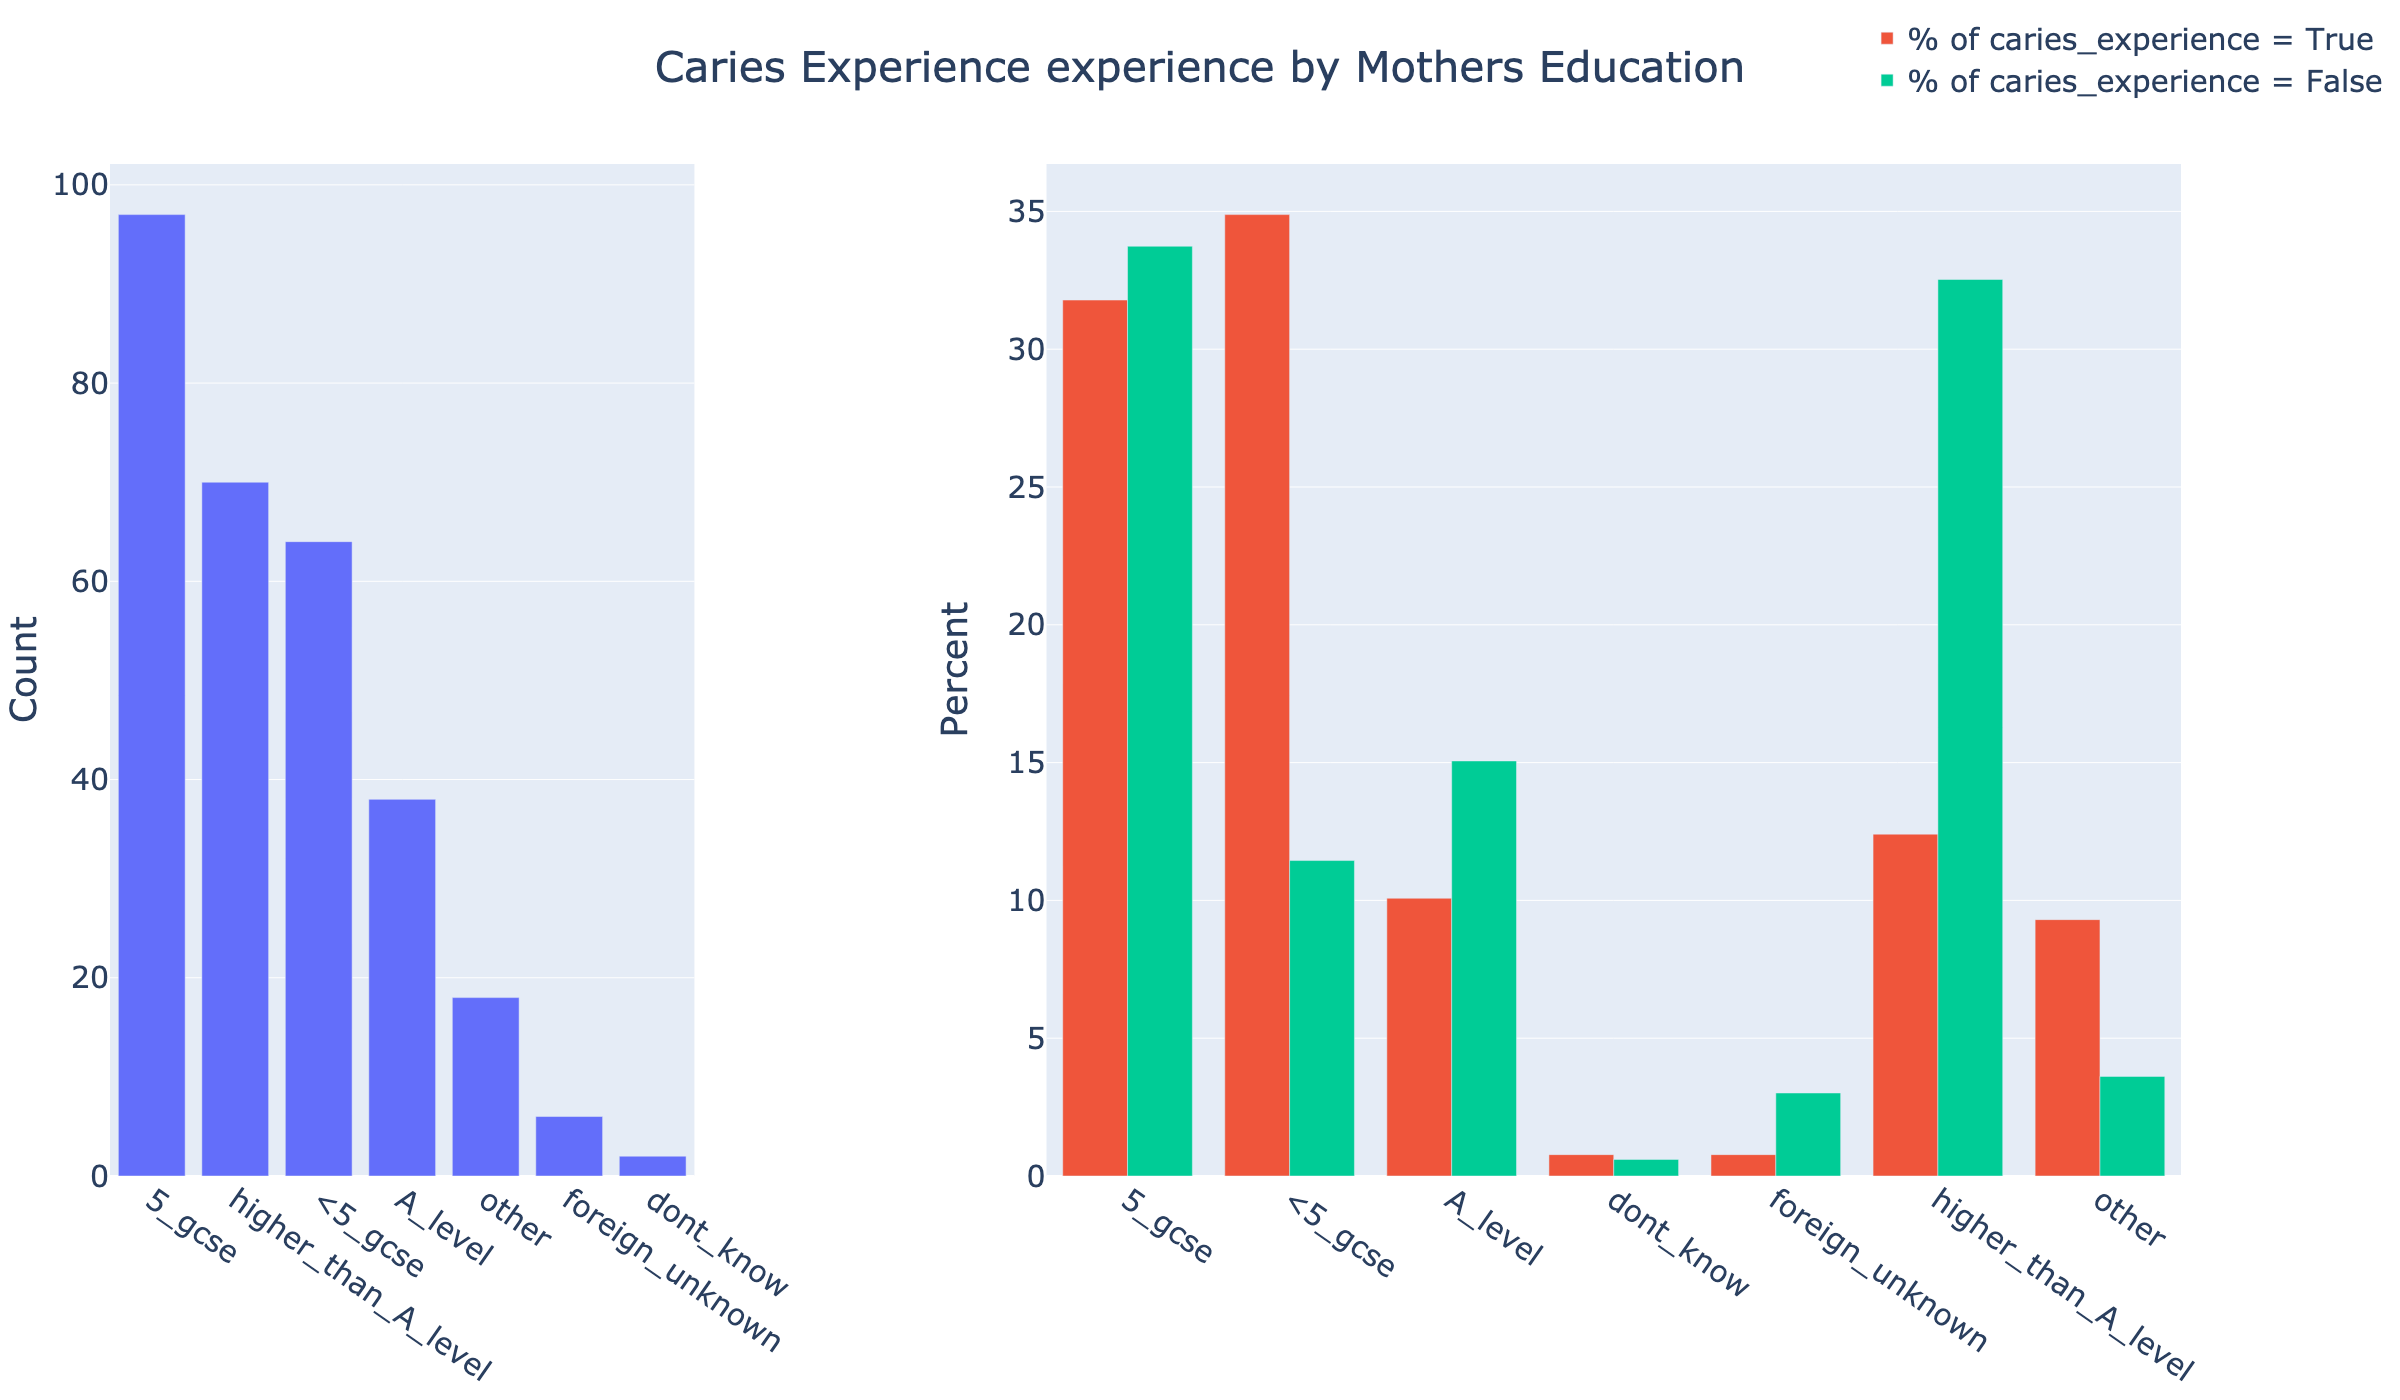

In [6]:
plot_target_rate_comparison(baseline_caries,
                            "mothers_education",
                            "caries_experience")

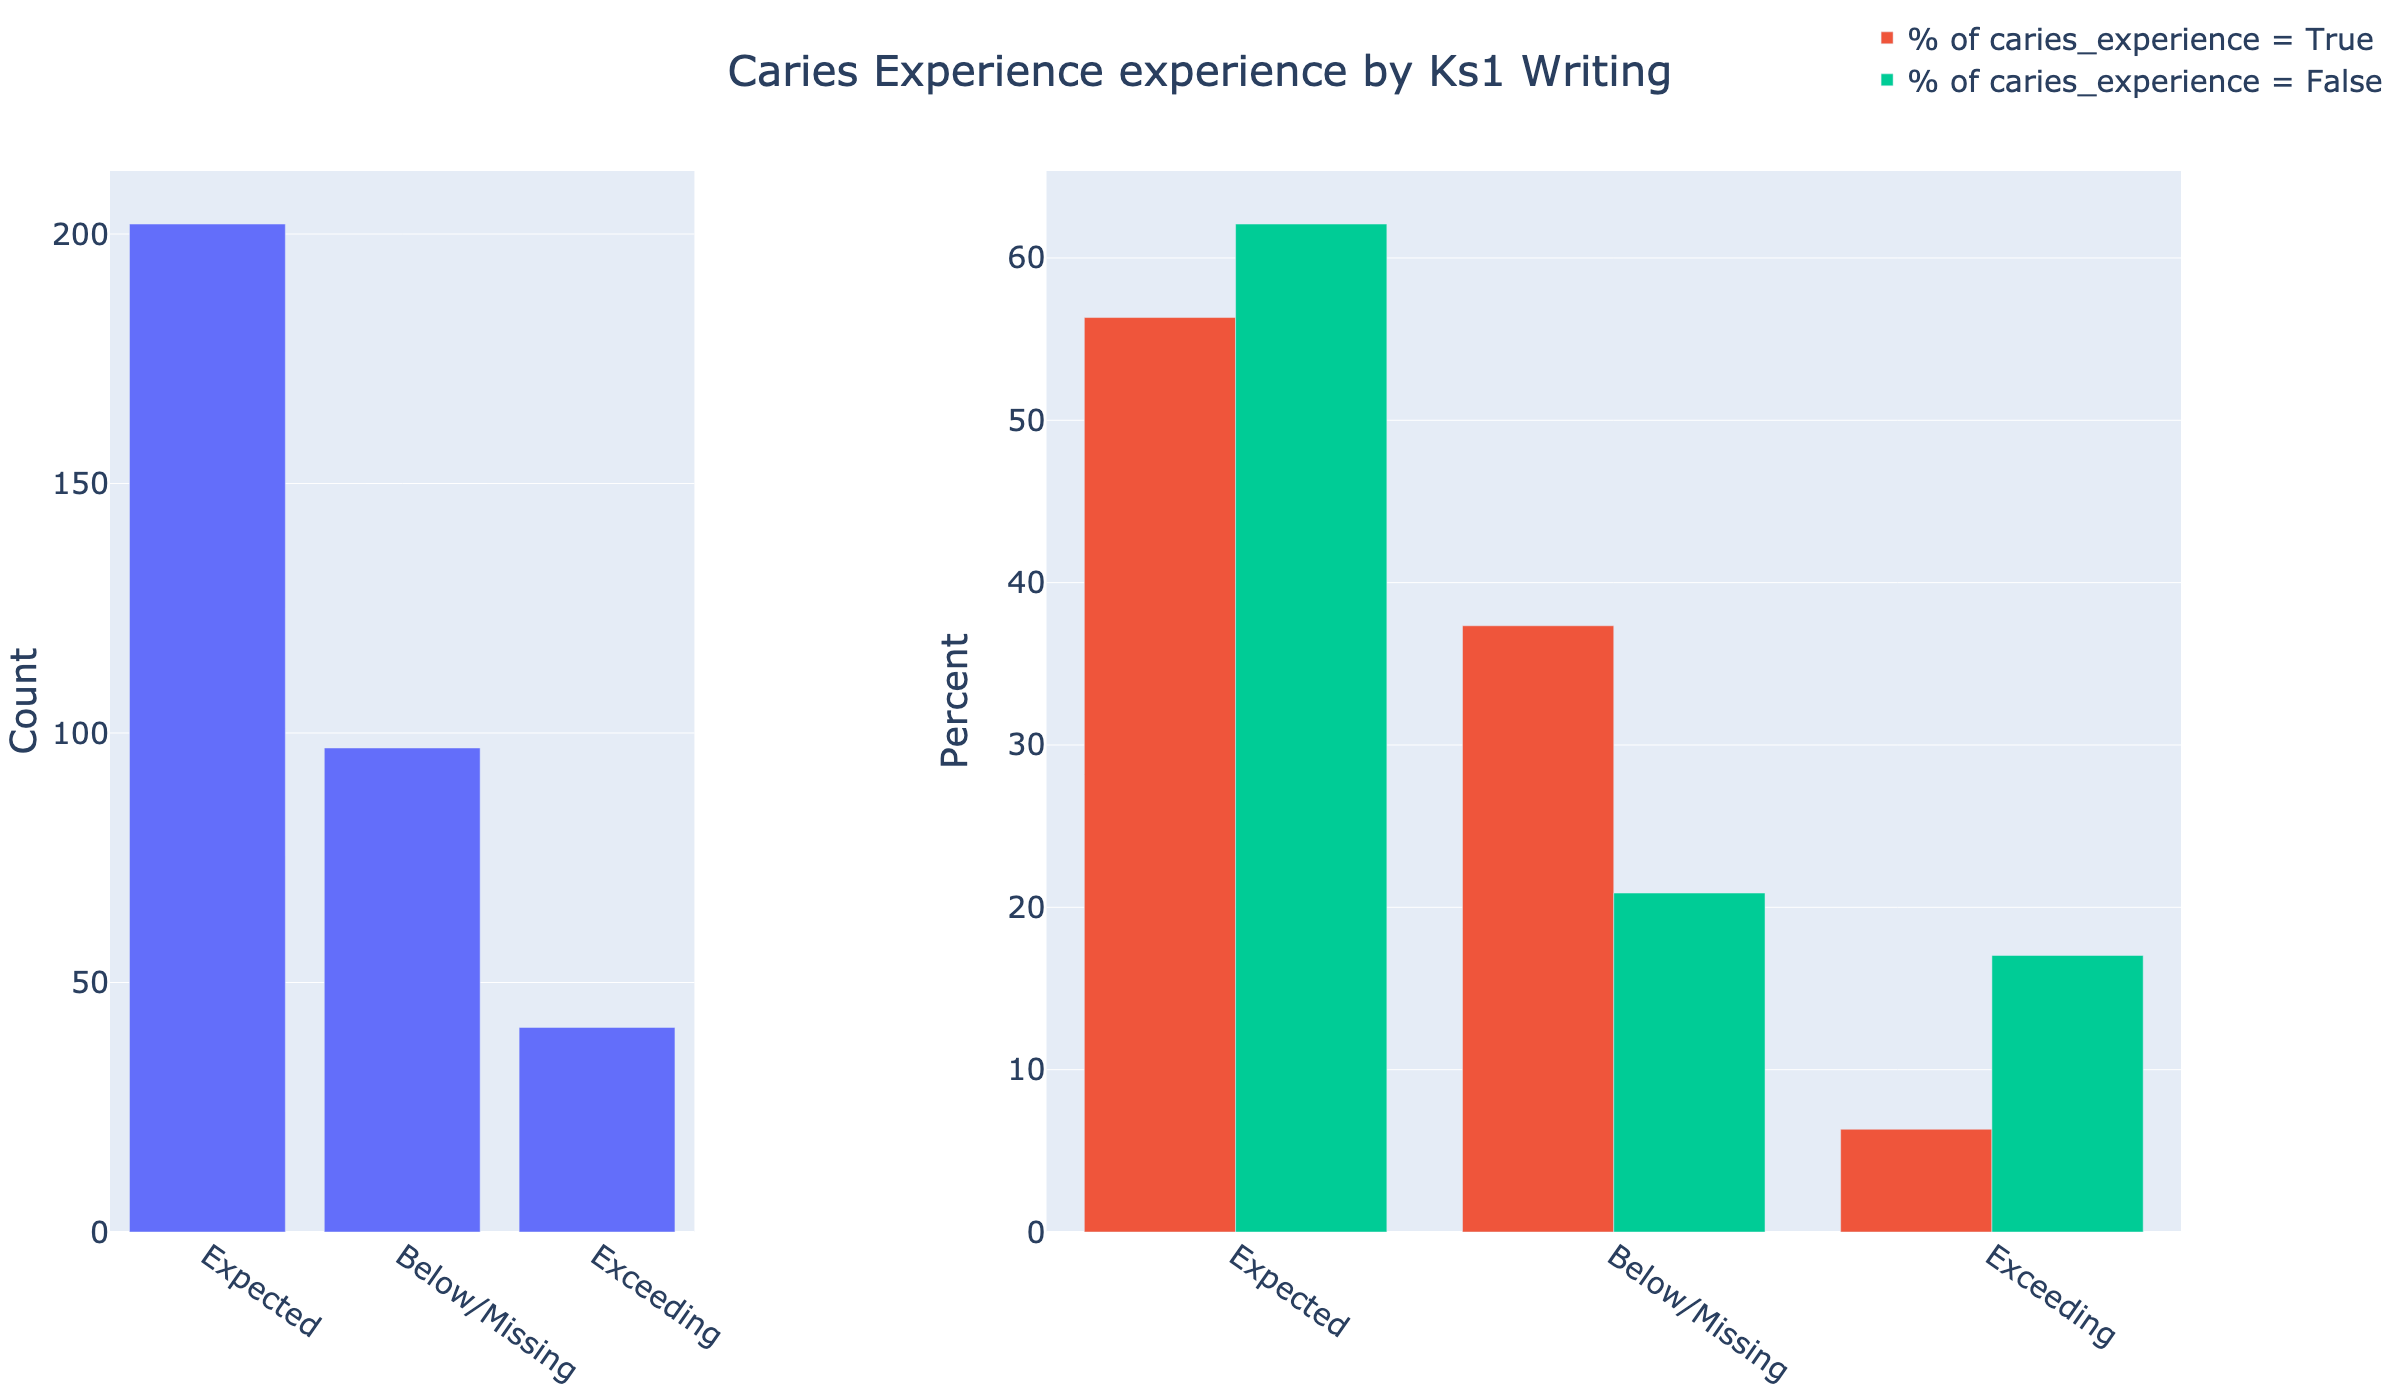

In [7]:
plot_target_rate_comparison(edrecs_caries,
                            "ks1_writing",
                            "caries_experience")

In [28]:
def plot_group_comparison(df, feature, target, plot_title=None,
                                percentages=True):
    fig = go.Figure()

    df = df[[feature, target]].copy()
    df["count"] = np.ones(len(df))
    feature_counts = (df.groupby([feature, target])
                      .agg("count").reset_index())
    for has_ga in [1, 0]:

        ga_map = feature_counts[target] == has_ga
        counts = feature_counts[ga_map]["count"].values
        sum = counts.sum()
        feature_counts.loc[ga_map, "pct"] = counts * 100 / sum

        outcome = "Caries Experience" + " = True" if has_ga == 1 else "Caries Experience" + " = False"
        name = f"{outcome}"

        if percentages:
            pct_chart = go.Bar(x=feature_counts[ga_map][feature],
                               y=feature_counts[ga_map]["pct"],
                               name=name)
        else:
            pct_chart = go.Bar(x=feature_counts[ga_map][feature],
                               y=feature_counts[ga_map]["count"],
                               name=name)

        fig.add_trace(pct_chart)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=1.15,
        xanchor="right",
        x=1.1
    ))


    target_name = target.replace("_", " ").title()
    feature_name = feature.replace("_", " ").title()
    if plot_title is None:
        plot_title = (f"{target_name} experience by {feature_name}")
    fig.update_xaxes(tickangle=35)
    fig.update_layout(
        width=2000,
        height=1400,
        title=dict(text=plot_title,
                   x=0.5),
        font=dict(size=30)
    )
    fig_image = fig.to_image(format="png")
    display(Image(fig_image))

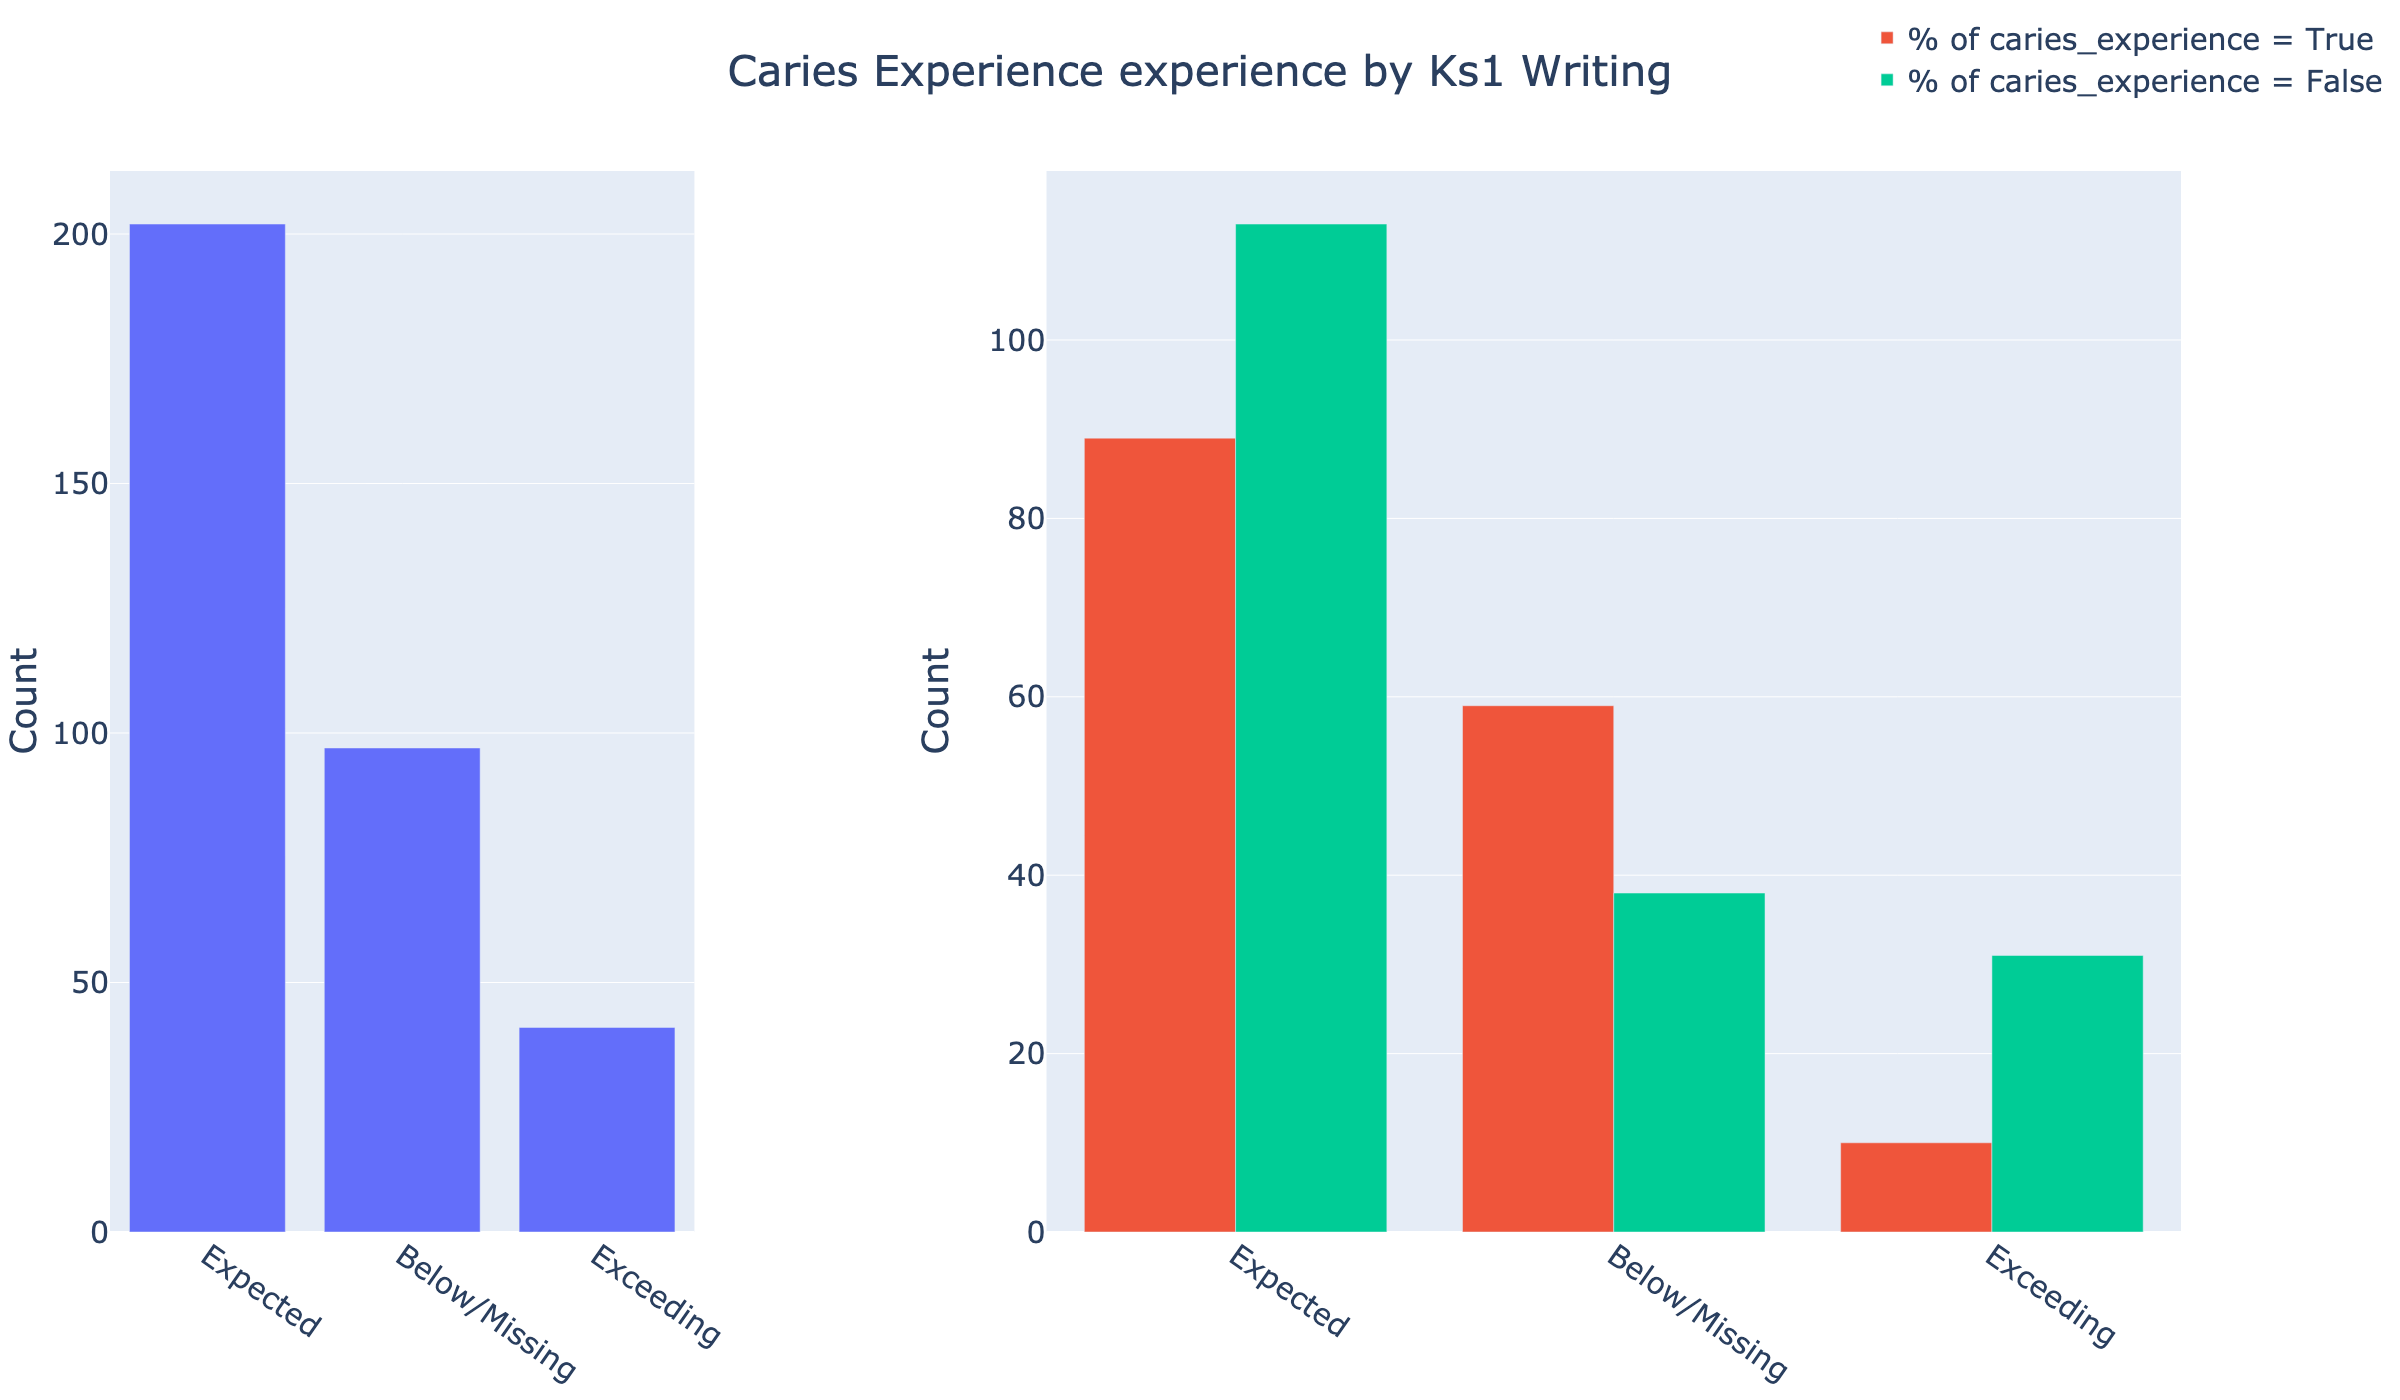

In [29]:
plot_target_rate_comparison(edrecs_caries,
                            "ks1_writing",
                            "caries_experience",
                            percentages=False)

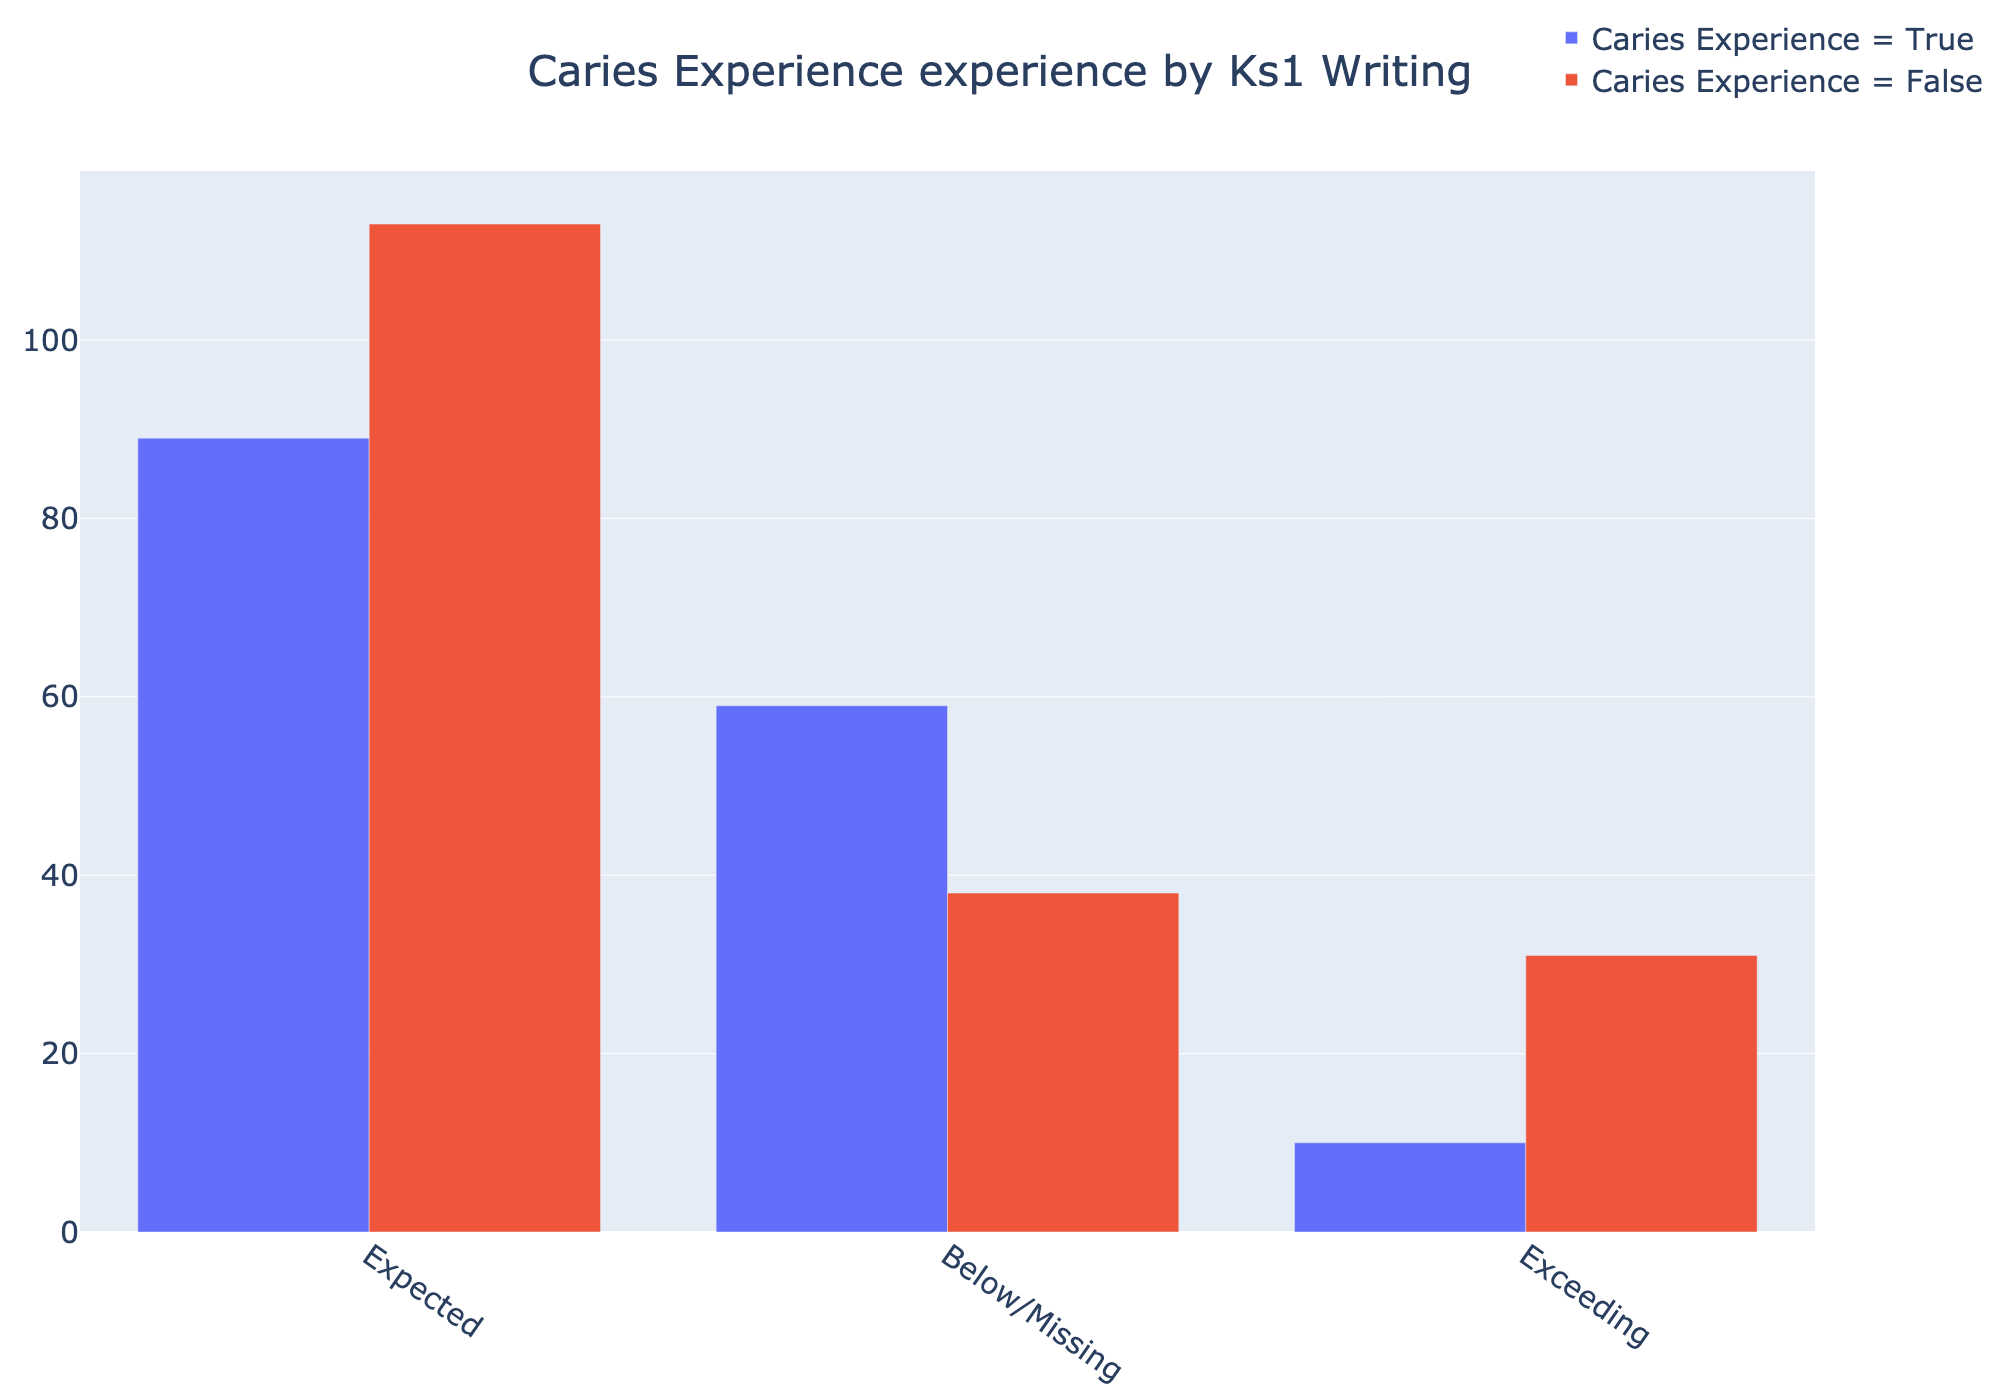

In [30]:
plot_group_comparison(edrecs_caries,
                            "ks1_writing",
                            "caries_experience",
                            percentages=False)

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



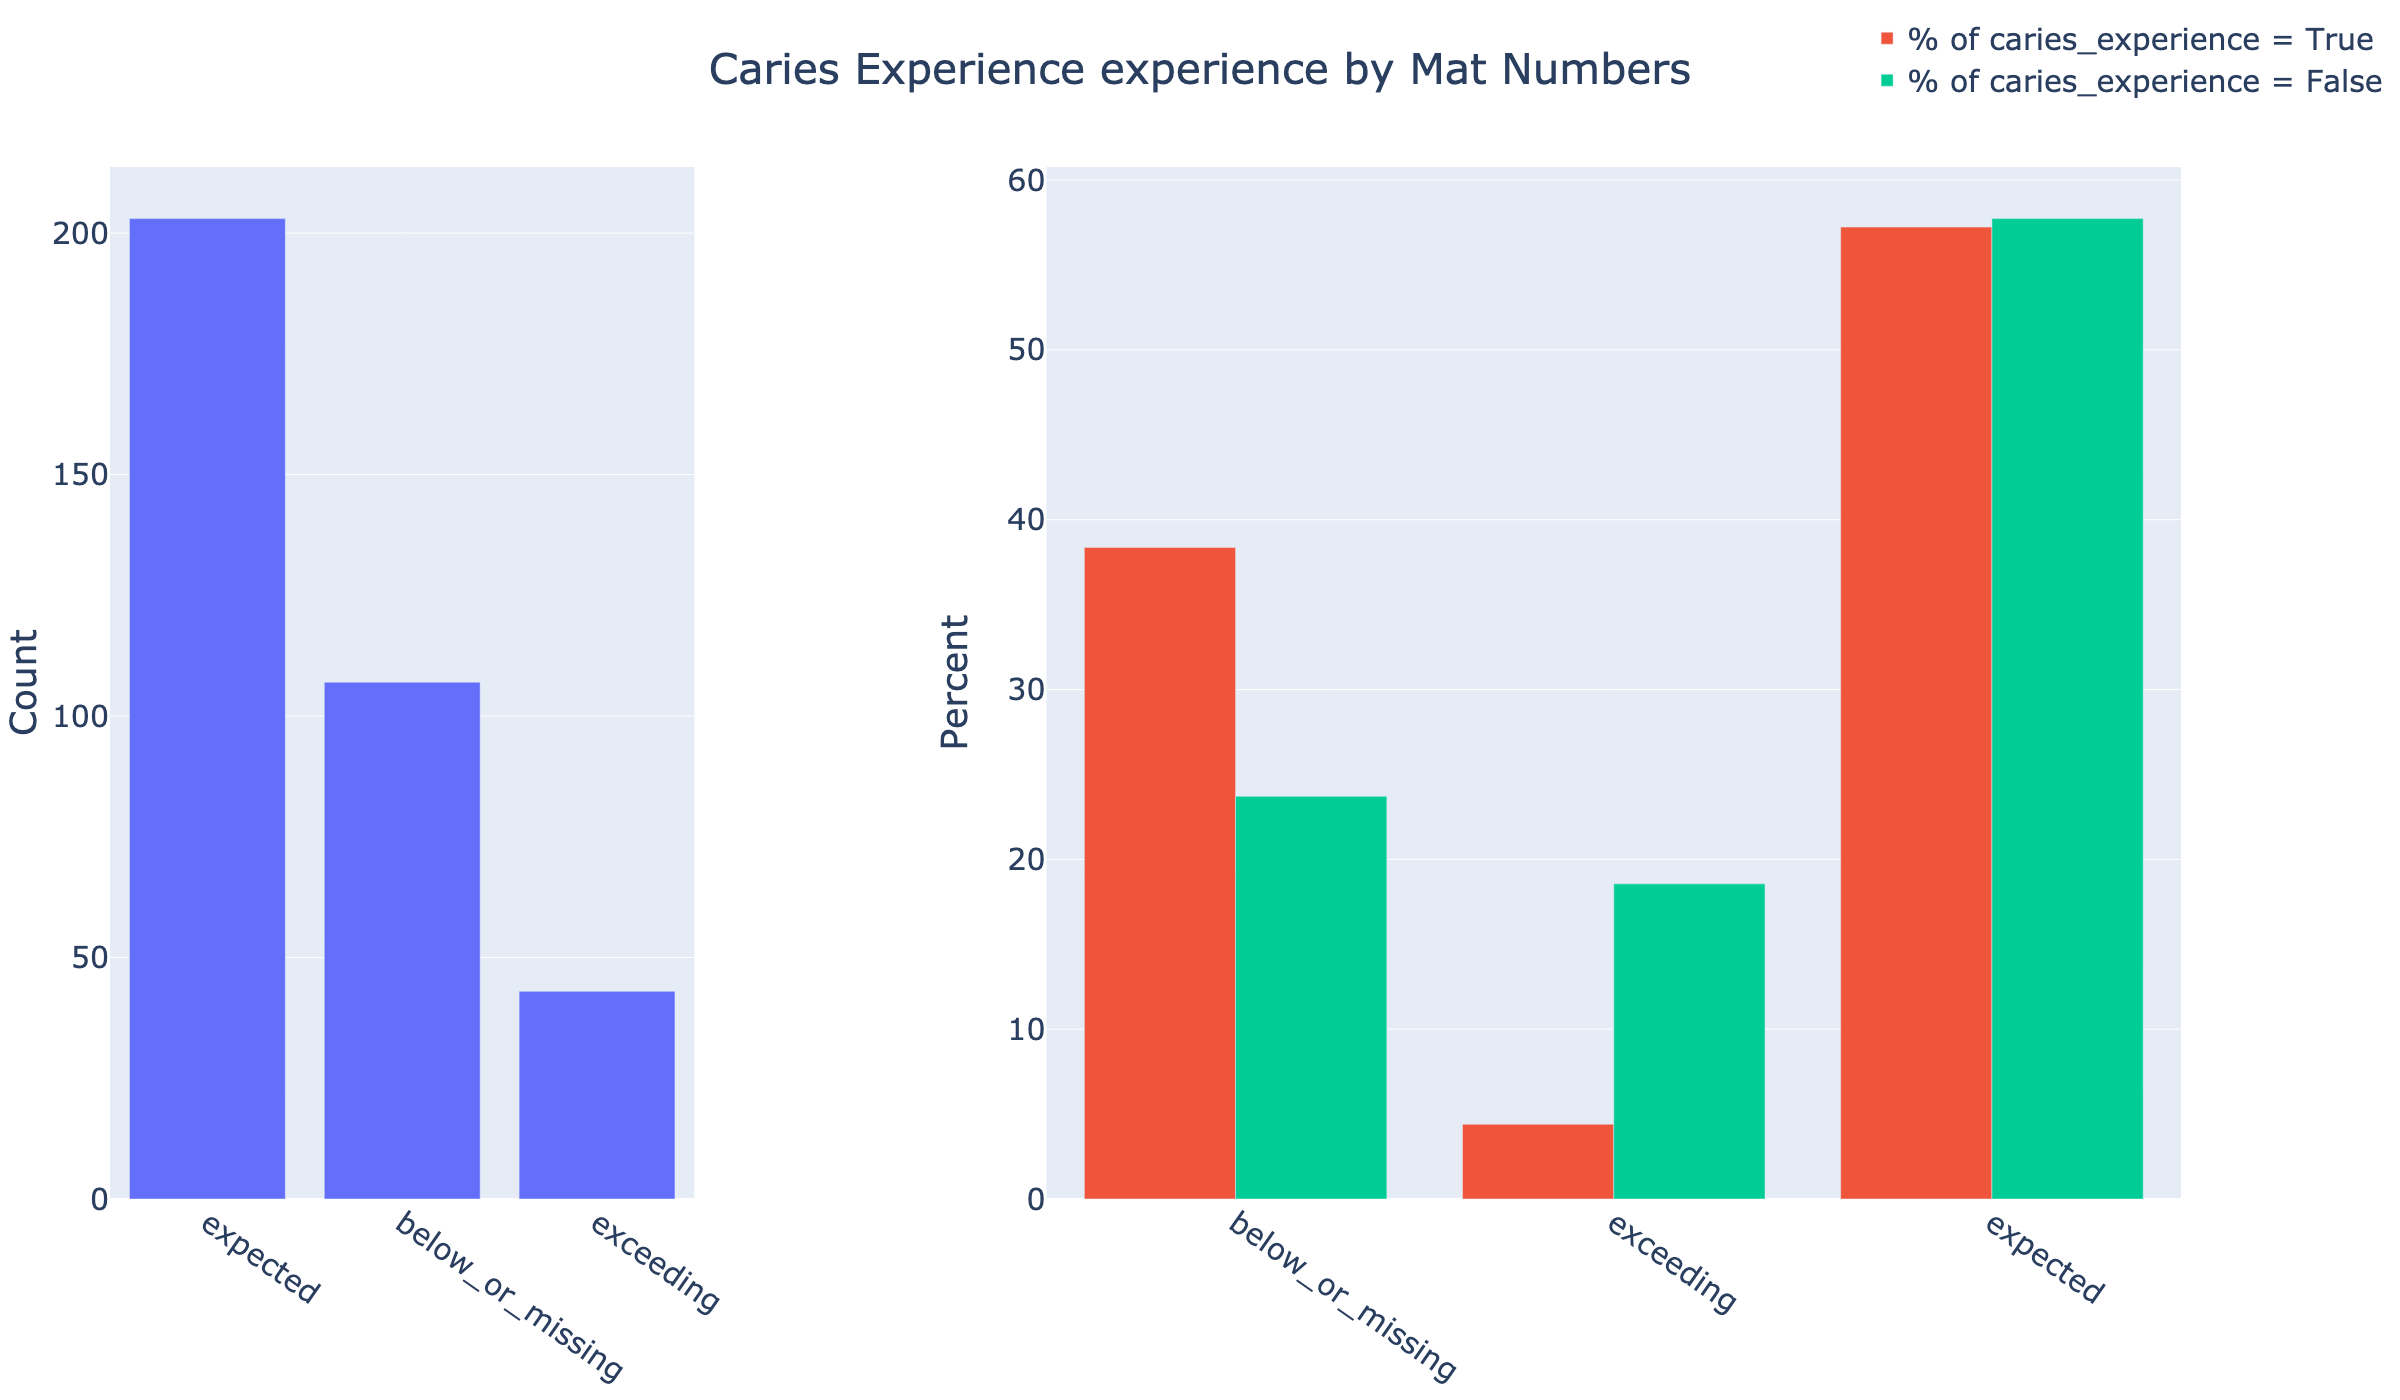

In [9]:
plot_target_rate_comparison(edrecs_caries,
                            "mat_numbers",
                            "caries_experience")


### Methods:

As with the GA analysis, we fit a simple logistic regression models and a Gradient Boosted Decision Tree Classifier for the education records data, the baseline data and a merging of the two. The model ROC AUC scores give an estimation of how well these observations "describe" the caries experience target, and comparing the linear / tree methods tells us if there are any strong non-linear relationships that the regression models don't capture.

Unlike the GA analysis, the very small datasets present a couple of additional challenges:
* **Colinearity**: The limited observations show near perfect colinearity in a number of cases, which makes fitting a logistic regression classifier mathematically unfeasible. As such, some variables are omitted from each model. In particular, we'll see only a small subset of the variables in the final "merged" dataset - these were selected by fitting linear models with each individual variable and choosing the 10 variables with the highest R squared values (results from this analysis are reported).

* **Overfitting**: Given the size of the epi dataset, there's very little data on which to train and evaluate each model. As a result, each of the trained logistic regression models overfit significantly - they fit the distribution of the training data too closely and so fail to generalise well on unseen data (the gradient boosted models less so, as they have a nice cross-validation feature). To combat the overfitting, a "lasso" logistic regression model was fitted for each dataset, alongside the un-regularised regression models.

### Results

A table showing the respective scores of each model can be seen in ** APPENDIX **. Each of the logistic regression coefficients can also be found in ** APPENDIX **

ROC curves can be seen in the following figures. To the uninitiated, these are a means of visualising the AUC score - indeed AUC measures the geometric area under the ROC curve. The plots show the true positive and false positive rates for different threshold probabilities of classifying a prediction as positive or, in this case, as having caries experience. Higher AUCs mean a model that is better able to distinguish between the classes - in the visualisations, the curves that enclose a greater area (stretch up to the top left hand corner of the plot) have a higher AUC:

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



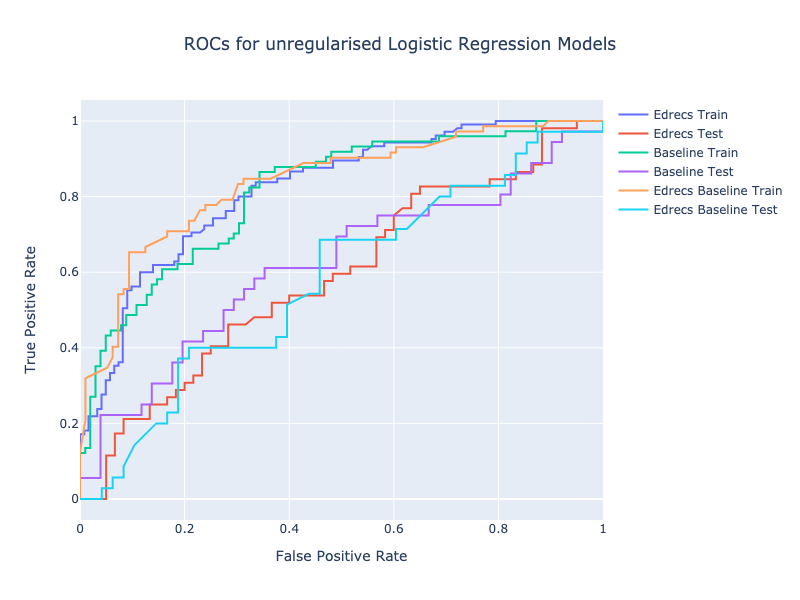

In [10]:
plot_roc_curves(log_reg_roc_curves,
                title="ROCs for unregularised Logistic Regression Models")

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



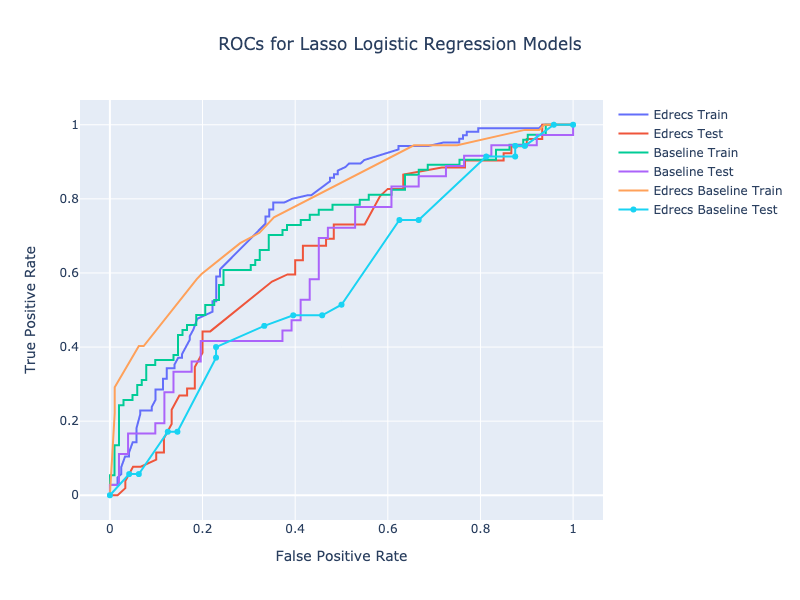

In [11]:
plot_roc_curves(las_reg_roc_curves,
                title="ROCs for Lasso Logistic Regression Models")

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



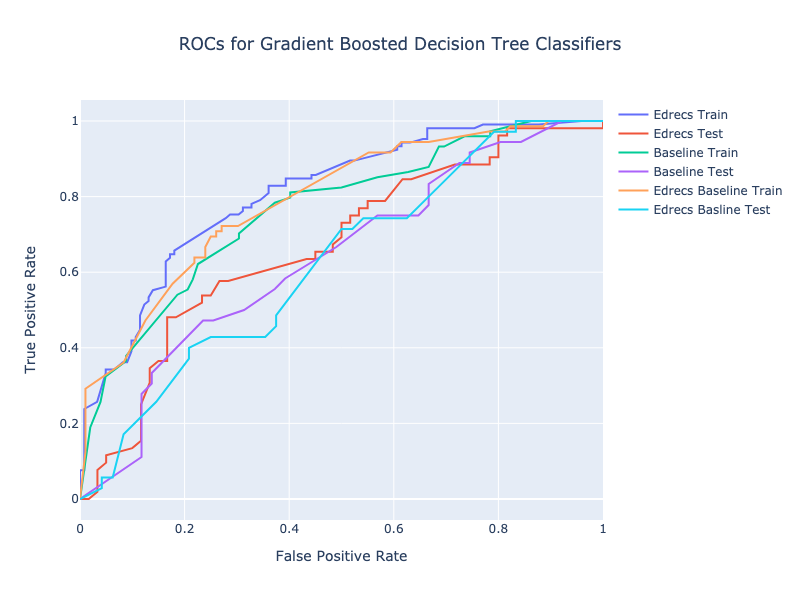

In [12]:
plot_roc_curves(gb_roc_curves,
                title="ROCs for Gradient Boosted Decision Tree Classifiers")

Key points to note are:

* The results on the training data are significantly better than seen with the GA models (AUCs in the region of 0.7-0.8). This suggests that the caries experience target shows greater promise, as it is much better explained by the BiB data in each instance.
* The test set AUCs for the each model are much lower than their train set counterparts, in some cases dramatically so (note the obvious separation between the training curves and the test curves in the vanilla logistic regression models). This is the overfitting referred to above.
* The test set AUCs for the lasso logistic regression models are closer to the respective training set scores in some cases, but others they are the same as the vanilla models. Its reasonable to think this is caused by the lack of training data - there simply isn't enough information in the training set distribution to prevent the models from fitting to noise.
* The gradient boosted tree classifiers don't show a significantly better performance than their linear counterparts, suggesting the relationship between caries experience and the input observations is sufficiently linear for their performance to be comparable.
* The results from each of the different datasets are remarkably similar. This suggests the variance in the input observations are capturing similar "information" about caries experience, despite measuring outwardly different phenomena

Its also worth looking at the coefficients of the lasso logistic regression models more closely. Lasso logistic regression includes a penalty weighting against the model coefficients - this "forces" the model to choose only input variables that are most associated with the outcome variable / target. This results in a "sparse" set of coefficients, or a subset of the input data that is most associated with the output.

The model trained on the most descriptive of the variables in both the education records and baseline datasets highlights "mother's education", "literature - reading", "self confidence and awareness" and "maths - shapes and measures" as the variables most associated with caries experience.

The R squared values for the models trained with only one input variable are also shown in APPENDIX. These give an indication of how well each individual variable explains caries experience - though note that several of these features are highly correlated, so some variables will be "explaining" roughly the same thing as others.

## Conclusions

These results show that the caries experience target is much more promising to model using the BiB data. The models in this analysis are much better at explaining the data they were trained on - unfortunately this doesn't generalise well to unseen data points, but this is likely a result of the tiny amount of training data available. In an ideal world we would collect many more observations of dmft / DMFT in 6-year-olds, with the prospect of identifying promising non-health determinants of bad oral health.

Next on the order of business is analysis of the PLATOON data, to see if similar performance can be seen there.

In [14]:
# generate table 1 of merged edrecs epi data

pd.set_option("display.max_rows", None)

eb_cols = list(eb_caries.drop("entity_id", axis=1).columns)
eb_numerical = ["phonics_mark1", "caries_experience", "mothers_bmi"]
eb_categorical = [col for col in eb_cols
                  if not col in eb_numerical]

eb_tab = TableOne(eb_caries.drop("entity_id", axis=1),
                  columns=eb_cols,
                  categorical=eb_categorical,
                  groupby="caries_experience",
                  pval=True)
eb_tab

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Grouped by caries_experience                                               
                                                                                   Missing      Overall            0            1 P-Value
n                                                                                                   354          194          160        
on_benefits, n (%)                     no                                               60   106 (36.1)    67 (40.6)    39 (30.2)   0.086
                                       yes                                                   188 (63.9)    98 (59.4)    90 (69.8)        
fathers_education, n (%)               5_gcse                                           60    74 (25.2)    43 (25.9)    31 (24.2)   0.030
                                       <5_gcse                                                51 (17.3)    20 (12.0)    31 (24.2)        
                                       A_level                                                 28 (9.5)     15 (9.0)    13 (10.2)        
                                       dont_know                                              50 (17.0)    25 (15.1)    25 (19.5)        
                                       foreign_unknown                                          4 (1.4)      3 (1.8)      1 (0.8)        
                                       higher_than_A_level                                    75 (25.5)    53 (31.9)    22 (17.2)        
                                       other                                                   12 (4.1)      7 (4.2)      5 (3.9)        
mothers_education, n (%)               5_gcse                                           59    97 (32.9)    56 (33.7)    41 (31.8)  <0.001
                                       <5_gcse                                                64 (21.7)    19 (11.4)    45 (34.9)        
                                       A_level                                                38 (12.9)    25 (15.1)    13 (10.1)        
                                       dont_know                                                2 (0.7)      1 (0.6)      1 (0.8)        
                                       foreign_unknown                                          6 (2.0)      5 (3.0)      1 (0.8)        
                                       higher_than_A_level                                    70 (23.7)    54 (32.5)    16 (12.4)        
                                       other                                                   18 (6.1)      6 (3.6)     12 (9.3)        
mothers_ethnicity, n (%)               other                                            59    42 (14.2)    25 (15.1)    17 (13.2)   0.163
                                       pakistani                                             151 (51.2)    77 (46.4)    74 (57.4)        
                                       white_british                                         102 (34.6)    64 (38.6)    38 (29.5)        
managing_financially, n (%)            doing_alright                                    59   128 (43.4)    73 (44.0)    55 (42.6)   0.522
                                       just_about_getting_by                                  65 (22.0)    32 (19.3)    33 (25.6)        
                                       living_comfortably                                     76 (25.8)    47 (28.3)    29 (22.5)        
                                       quite_difficult                                         22 (7.5)     11 (6.6)     11 (8.5)        
                                       very_difficult                                           4 (1.4)      3 (1.8)      1 (0.8)        
married_cohabiting, n (%)              married_n_cohabiting                             59   221 (74.9)   126 (75.9)    95 (73.6)   0.053
                                       married_not_cohabiting                                 35 (11.9)    24 (14.5)     11 (8.5)        
                                       not_cohabiting       

In [15]:
eb_tab.to_latex("arse_pain.tex")

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [16]:
print(edrecs_unreg_results.summary())

                           Logit Regression Results                           
Dep. Variable:      caries_experience   No. Observations:                  227
Model:                          Logit   Df Residuals:                      178
Method:                           MLE   Df Model:                           48
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                  0.2626
Time:                        11:00:10   Log-Likelihood:                -115.55
converged:                       True   LL-Null:                       -156.71
Covariance Type:            nonrobust   LLR p-value:                  0.001501
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -0.8726      0.956     -0.913      0.361      -2.746       1.001
com_listening_attention[T.exc

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [17]:
print(edrecs_reg_results.summary())

                           Logit Regression Results                           
Dep. Variable:      caries_experience   No. Observations:                  227
Model:                          Logit   Df Residuals:                      208
Method:                           MLE   Df Model:                           18
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                  0.1355
Time:                        11:00:10   Log-Likelihood:                -135.47
converged:                      False   LL-Null:                       -156.71
Covariance Type:            nonrobust   LLR p-value:                 0.0009480
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                             0        nan        nan        nan         nan         nan
com_listening_attention[T.exc

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [18]:
print(base_unreg_results.summary())

                           Logit Regression Results                           
Dep. Variable:      caries_experience   No. Observations:                  176
Model:                          Logit   Df Residuals:                      145
Method:                           MLE   Df Model:                           30
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                  0.2423
Time:                        11:00:10   Log-Likelihood:                -90.746
converged:                      False   LL-Null:                       -119.76
Covariance Type:            nonrobust   LLR p-value:                  0.001587
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -1.3394      1.349     -0.993      0.321      -3.984       1.305
on_benefits[T.yes]           

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [19]:
print(base_reg_results.summary())

                           Logit Regression Results                           
Dep. Variable:      caries_experience   No. Observations:                  176
Model:                          Logit   Df Residuals:                      172
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                 0.09500
Time:                        11:00:10   Log-Likelihood:                -108.38
converged:                       True   LL-Null:                       -119.76
Covariance Type:            nonrobust   LLR p-value:                 4.546e-05
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                             0        nan        nan        nan         nan         nan
on_benefits[T.yes]           

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [20]:
print(eb_unreg_results.summary())

                           Logit Regression Results                           
Dep. Variable:      caries_experience   No. Observations:                  168
Model:                          Logit   Df Residuals:                      141
Method:                           MLE   Df Model:                           26
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                  0.2834
Time:                        11:00:10   Log-Likelihood:                -82.214
converged:                      False   LL-Null:                       -114.73
Covariance Type:            nonrobust   LLR p-value:                 3.413e-05
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.0833      0.737      0.113      0.910      -1.362       1.528
mothers_education[T.<5_gcse] 

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [21]:
print(eb_reg_results.summary())

                           Logit Regression Results                           
Dep. Variable:      caries_experience   No. Observations:                  168
Model:                          Logit   Df Residuals:                      163
Method:                           MLE   Df Model:                            4
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                  0.1424
Time:                        11:00:10   Log-Likelihood:                -98.395
converged:                       True   LL-Null:                       -114.73
Covariance Type:            nonrobust   LLR p-value:                 1.397e-06
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                             0        nan        nan        nan         nan         nan
mothers_education[T.<5_gcse] 

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [22]:
pd.DataFrame(model_scores)

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Data,Model Type,Pseudo R^2,Train ROC AUC,Test ROC AUC
0,edrecs,Logistic Regression,0.262644,0.821429,0.590064
1,edrecs,Lasso Logistic Regression,0.135532,0.750664,0.643750
2,edrecs,Gradient Boosted Trees,NaN,0.826425,0.668590
3,Baseline,Logistic Regression,0.242252,0.813725,0.619281
4,Baseline,Lasso Logistic Regression,0.094997,0.715289,0.629630
5,Baseline,Gradient Boosted Trees,NaN,0.763447,0.636983
6,Edrecs + Baseline,Logistic Regression,0.283401,0.838035,0.580060
7,Edrecs + Baseline,Lasso Logistic Regression,0.142368,0.779948,0.570536
8,edrecs + Baseline,Gradient Boosted Trees,NaN,0.789569,0.625298


In [23]:
feature_scores

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,feature,prsquared
0,mothers_education,0.147365
1,lit_reading,0.084051
2,pse_self_confidence_awareness,0.080850
3,lit_writing,0.077436
4,utw_people_communities,0.072776
5,pse_managing_feelings_behaviour,0.068259
6,mat_numbers,0.063533
7,socio_economic_pos,0.058205
8,mat_shapes_space_measures,0.056010
9,exp_being_imaginative,0.050689


/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

